## Introduction
In Lessons 2 and 3, we treated forecasting as a simple regression problem with all of our features derived from a single input, the time index. We could easily create forecasts for any time in the future by just generating our desired trend and seasonal features.

When we added lag features in Lesson 4, however, the nature of the problem changed. Lag features require that the lagged target value is known at the time being forecast. A lag 1 feature shifts the time series forward 1 step, which means you could forecast 1 step into the future but not 2 steps.

In Lesson 4, we just assumed that we could always generate lags up to the period we wanted to forecast (every prediction was for just one step forward, in other words). Real-world forecasting typically demands more than this, so in this lesson we'll learn how to make forecasts for a variety of situations.

## Defining the Forecasting Task
There are two things to establish before designing a forecasting model:

- what information is available at the time a forecast is made (features), and,
- the time period during which you require forecasted values (target).

The **forecast origin** is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features.

The **forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.
<figure style="text-align:center;">
    <img src="https://storage.googleapis.com/kaggle-media/learn/images/xwEgcOk.png" />
    <figcaption style="font-style: italic;">A three-step forecast horizon with a two-step lead time, using four lag features. The figure represents what would be a single row of training data -- data for a single prediction, in other words.</figcaption>
</figure>

The time between the origin and the horizon is the **lead time** (or sometimes latency) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a <u>"1-step ahead"</u> or <u>"3-step ahead"</u> forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

## Preparing Data for Forecasting
In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms. (Unless, of course, you are only using deterministic features like trend and seasonality.)

We saw the first half of this process in Lesson 4 when we created a feature set out of lags. The second half is preparing the target. How we do this depends on the forecasting task.

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

In [1]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index = pd.period_range(
        start='2010',
        freq = 'A',
        periods = N,
        name = 'Year'
    )
)

# Lag features
X = pd.DataFrame(
    {
        f'y_lag_{i}': ts.shift(i) for i in range(2,7)
    }
)

# Multistep targets
y = pd.DataFrame(
    {
        "y_step_3": ts.shift(-2),
        "y_step_2": ts.shift(-1),
        "y_step_1": ts
    }
)
data = pd.concat(
    {
        "Targets":y,
        "Features":X
    },
    axis=1
)
data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})


The above illustrates how a dataset would be prepared similar to the Defining a Forecast figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is `y_step_1`. The missing values we could either fill-in or drop.


## Multistep Forecasting Strategies
There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses.

### Multioutput model
Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.
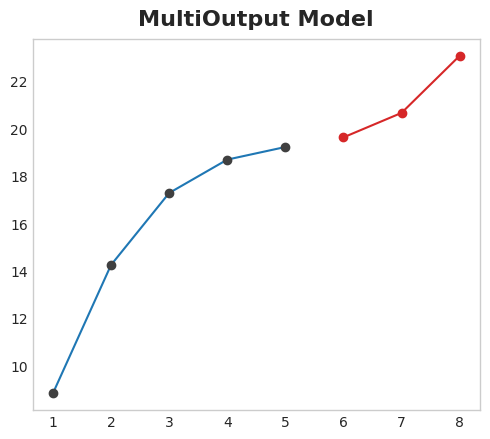
### Direct strategy
Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.
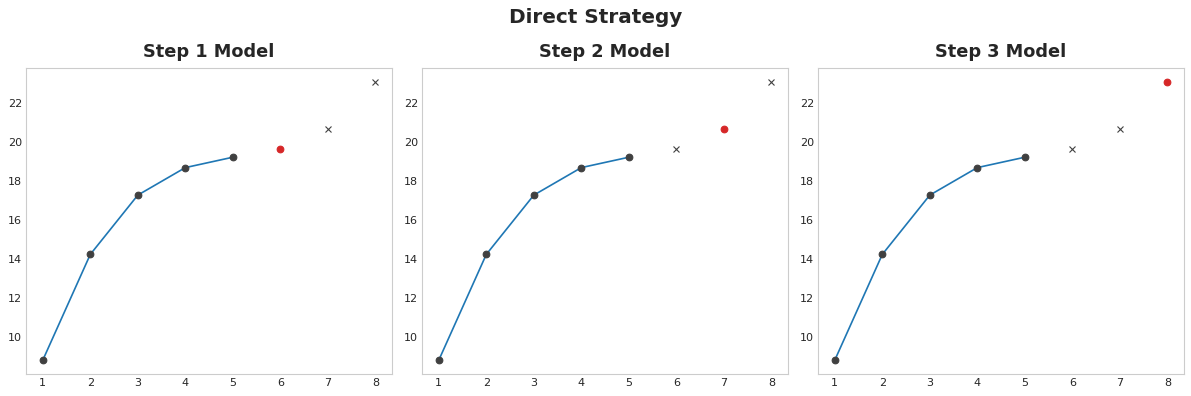
### Recursive strategy
Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.
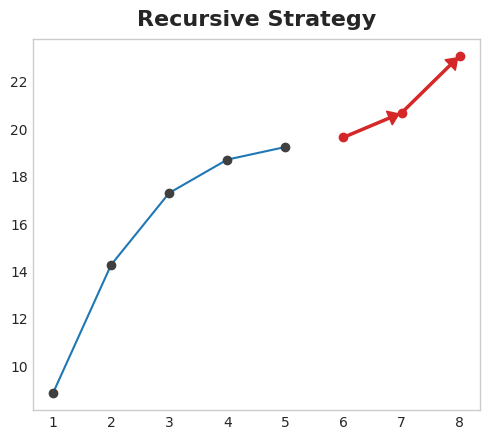
### DirRec strategy
A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.
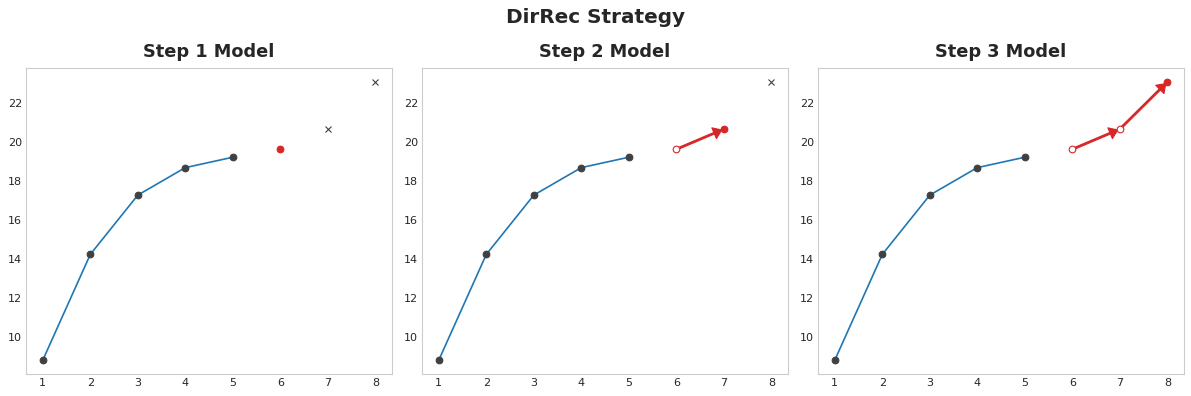


## Example - Flu Trends
In this example we'll apply the `MultiOutput` and Direct strategies to the *Flu Trends* data from Lesson 4, this time making true forecasts for multiple weeks beyond the training period.

We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

The hidden cell sets up the example and defines a helper function `plot_multistep`.

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("./ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(
        flu_trends.Week, 
        freq="W"
        ),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

In [13]:
flu_trends

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-30/2016-06-05,5,46,50,29,31,37,33,17,9,3,...,7,3,6,30,17,4,53,41,7,90
2016-06-06/2016-06-12,5,47,49,21,24,36,35,19,8,4,...,5,3,5,33,18,3,52,42,6,55
2016-06-13/2016-06-19,4,47,48,21,22,34,32,15,8,3,...,6,2,6,37,16,3,54,38,3,33


First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [14]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time,lead_time+lags)
        },
        axis=1
    )

# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y,lags=4).fillna(0.0)

def make_multistep_target(ts,steps):
    return pd.concat(
        {f'y_step_{i+1}':ts.shift(-i)
        for i in range(steps)},
        axis=1
    )
# Eight-week forecast
y = make_multistep_target(y,steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for 
# which we have both targets and features.
y, X = y.align(X, join='inner', axis = 0)


In [25]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time,lead_time+lags)
        },
        axis=1
    )

# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y,lags=4).fillna(0.0)

def make_multistep_target(ts,steps):
    return pd.concat(
        {f'y_step_{i+1}':ts.shift(-i)
        for i in range(steps)},
        axis=1
    )
# Eight-week forecast
y = make_multistep_target(y,steps=8).dropna()
y, X = y.align(X, join='inner', axis=0)
display(y)
display(X)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0
...,...,...,...,...,...,...,...,...
2016-04-11/2016-04-17,616,578.0,455.0,305.0,211.0,156.0,124.0,90.0
2016-04-18/2016-04-24,578,455.0,305.0,211.0,156.0,124.0,90.0,55.0
2016-04-25/2016-05-01,455,305.0,211.0,156.0,124.0,90.0,55.0,33.0


,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0
...,...,...,...,...
2016-04-11/2016-04-17,712.0,955.0,1100.0,1326.0
2016-04-18/2016-04-24,616.0,712.0,955.0,1100.0
2016-04-25/2016-05-01,578.0,616.0,712.0,955.0


### Multioutput model
We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
model = LinearRegression()
model.fit(X_train,y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index=X_train.index,
    columns = y.columns
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=X_test.index,
    columns=y.columns
)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

Train RMSE: 389.12
Test RMSE: 582.33


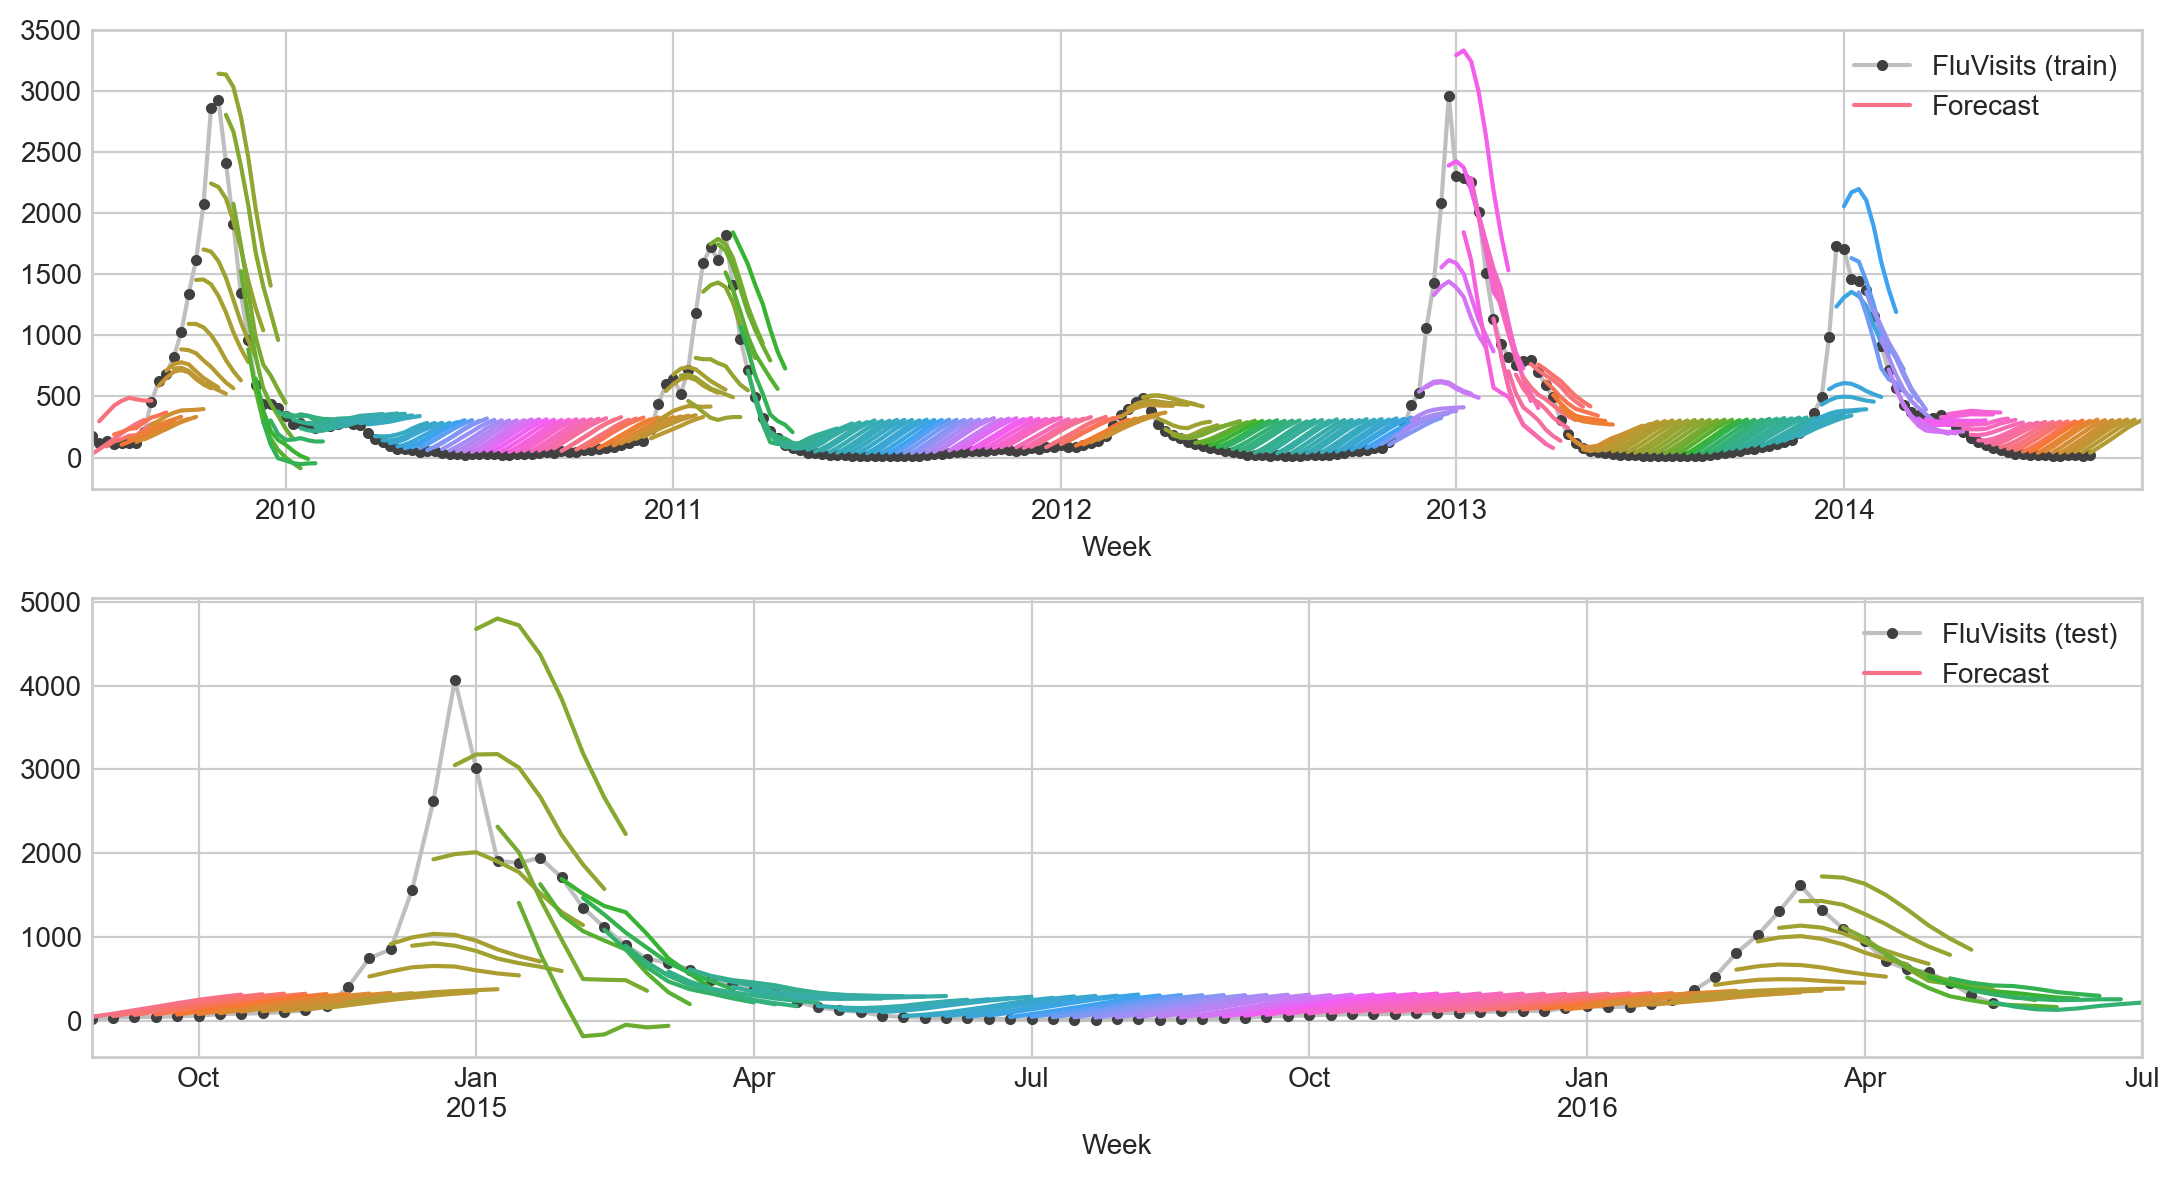

In [29]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2014-08-25/2014-08-31,47.100337,84.883562,126.162075,167.311492,209.825057,250.207311,283.654452,312.403024
2014-09-01/2014-09-07,55.892505,95.054026,136.675357,177.886897,218.165656,256.665631,289.113997,316.611490
2014-09-08/2014-09-14,70.311121,109.863705,150.933058,190.394310,229.238803,266.220484,297.152888,323.449643
2014-09-15/2014-09-21,74.375308,112.615330,151.658743,189.518258,227.133712,264.614526,295.904945,322.089465
2014-09-22/2014-09-28,74.132494,110.131429,147.487402,184.076652,222.279166,260.683261,292.300392,318.926953
...,...,...,...,...,...,...,...,...
2016-04-11/2016-04-17,516.796163,391.120264,292.082648,244.817163,202.197263,185.476604,177.057839,163.603480
2016-04-18/2016-04-24,527.736513,433.614891,376.587446,343.746771,333.696267,304.773898,277.978041,263.719032
2016-04-25/2016-05-01,506.147122,453.838827,421.989429,413.542560,383.362315,343.319737,318.983528,298.153698


### Direct strategy
XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's MultiOutputRegressor.

In [32]:
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

Train RMSE: 1.19
Test RMSE: 494.52


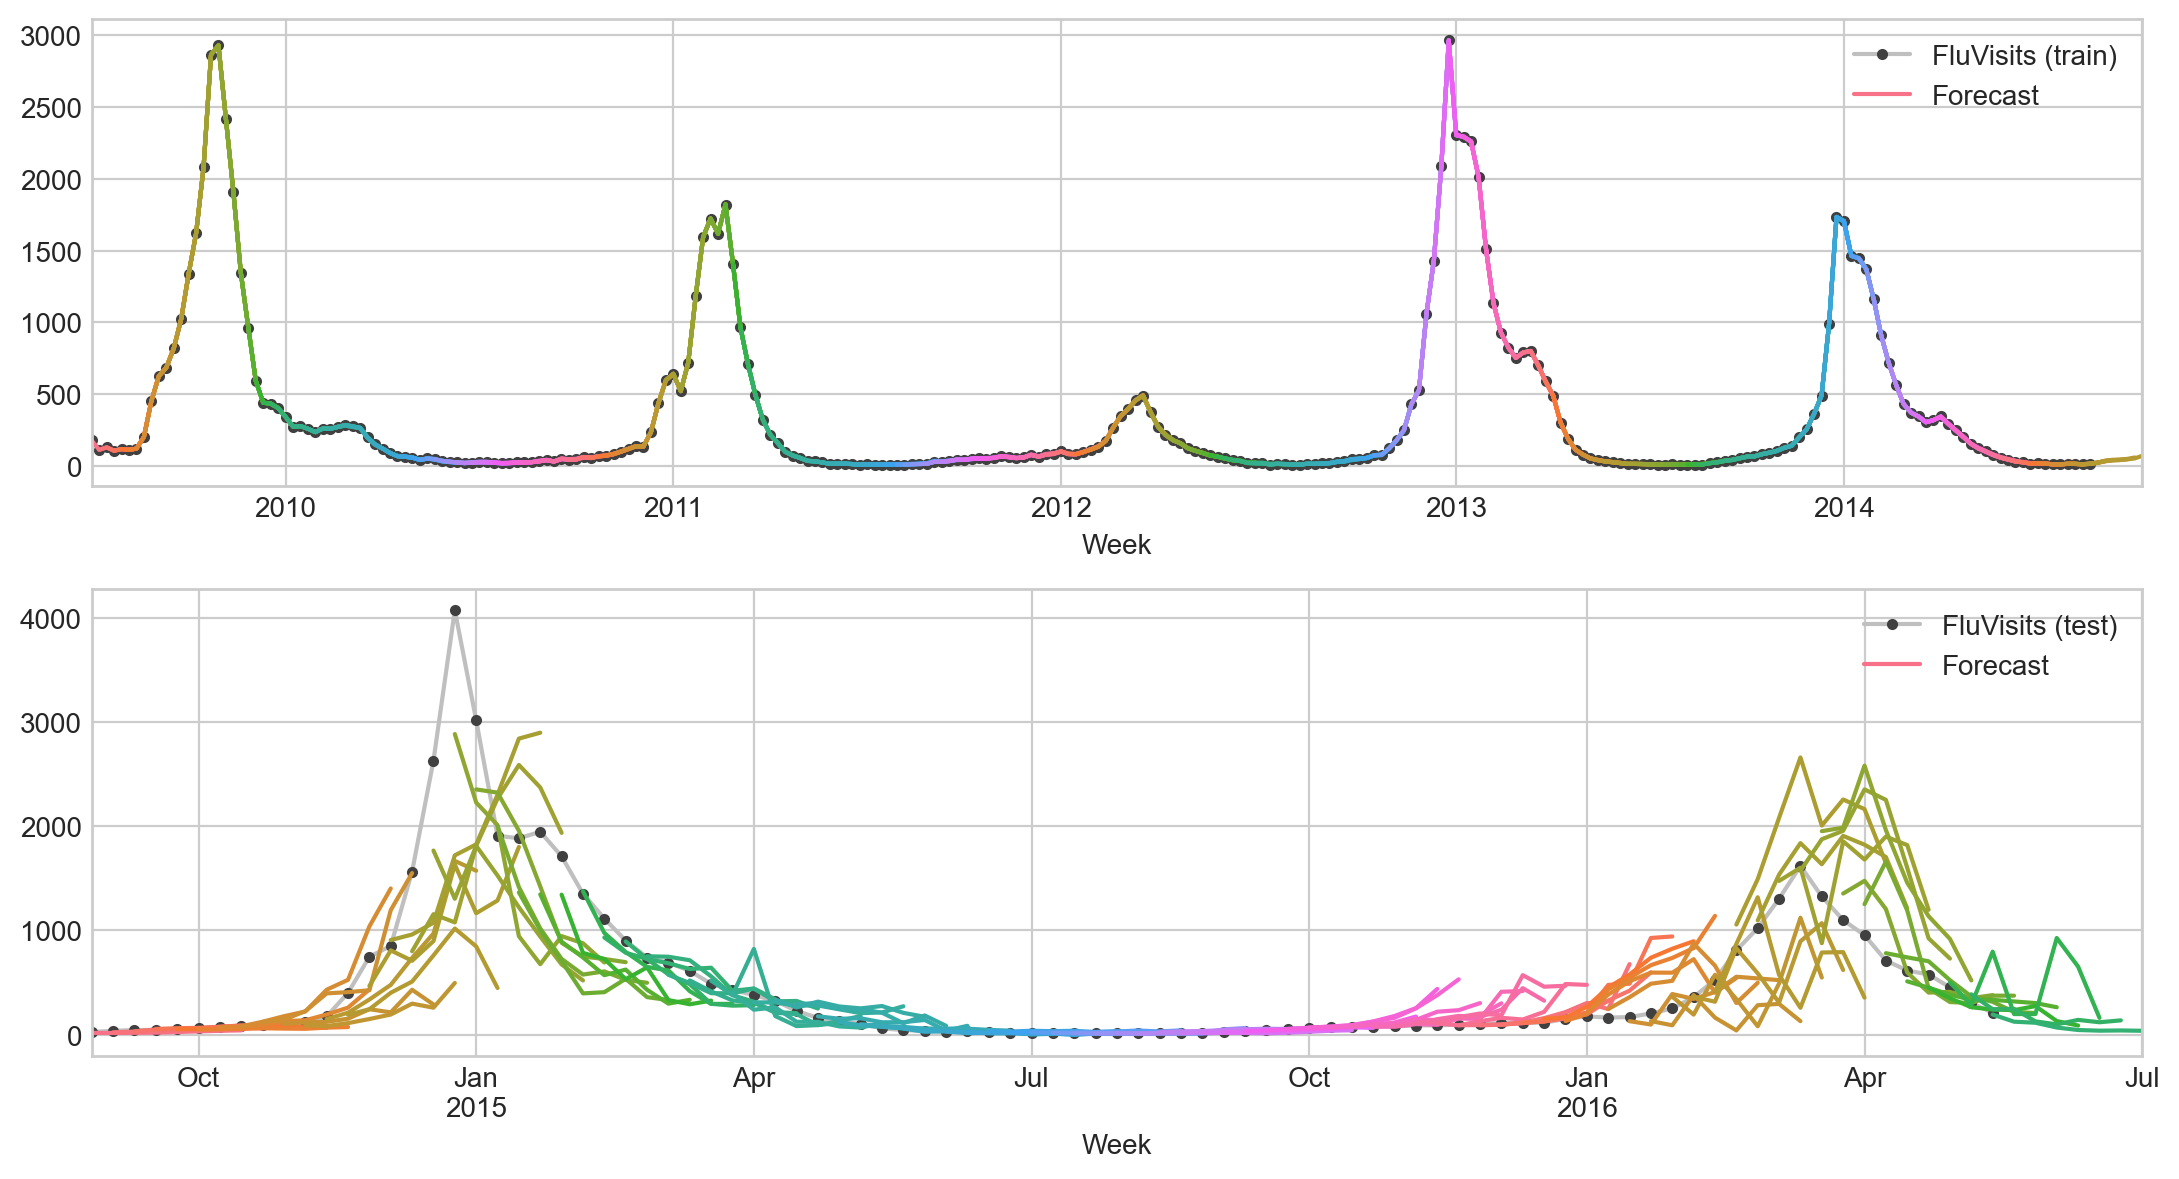

In [33]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])


To use the DirRec strategy, you would only need to replace `MultiOutputRegressor` with another scikit-learn wrapper, `RegressorChain`. The Recursive strategy we would need to code ourselves.